# Project 3: Density Functional Theory and Machine Learning

## Problem 2: Convergence Tests
In this problem you will be analyzing the results of convergence tests. In general, during a DFT structure optimization run the system's energy decreases with little fluctuation and eventually reaches the ground state. Reaching the ground state in this fashion is an example of convergence and is required for a meaningful run. To ensure that a new system converges it is necessary to perform proper convergence tests to avoid any chance of divergence or other situations where your system does not reach the ground state. Running without checking the following convergence can result in you ending up with incorrect results. The two most important convergence checks are ENCUT and the k-points mesh. 

### Part A: ENCUT convergence test

In the directory "convergence_test_results/ENCUT_convergence" you will find subdirectories that contain input files (POTCAR, POSCAR, INCAR, KPOINTS) and output files (OUTCAR, stdout) that correspond to convergence tests run for both diamond cubic and $\beta$-Sn silicon. For the DC-Si runs, the lattice parameter was set to the experimental value, 5.43 Angstroms, and the k-point sampling was set to 6x6x6. 

The ENCUT flag is found in the INCAR file while k-points can be set in the KPOINTS file.

$$ E_{cut} \geq \frac{1}{2} |k+G|^2$$

This sets the energy of the planwaves (PWs) that will be included. Only PWs with energies less than this cutoff energy are used in the calculation. ENCUT is generally in the range of 150 – 400 eV, default values for ENMIN and ENMAX are given in the POTCAR file. The value of ENCUT will vary depending on the setup and the system. 

The directory "convergence_test_results/ENCUT_convergence" contains the results for a scan through ENCUT for values between 150 and 350. You will make a plot of the final energy for each run vs. the ENCUT value and determine the maximum appropriate ENCUT. **You must find the correct value for ENCUT prior to proceeding any further in the project.**

---

In [15]:
import matplotlib.pyplot as plt
from math import log

# Helper function to plot convergence test data.
def plot_convergence(parameters, energies, xlabel="Cutoff Energy, $E_{cut} $ (eV)", 
                     ylabel="Energy (eV/atom)", save_fig=False, filename="DC_ENCUT_conv.png"):
    """Helper function to create convergence plots. 
    
    Arguments:
        parameters (list of int/float): independent variable (e.g. ENCUT or KPOINTS)
        energies (list of float): resulting final energies
        xlabel (str): label for the x-axis
        ylabel (str): label for you y-axis
        """
    
    # plot the data
    plt.plot(parameters, energies, 'rx')
    plt.plot(parameters, energies, 'b-')
    
    # add labels to the plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # saves the plot in convergence_test_results/plots/ (WILL OVERWRITE FILES IF FILENAME IS NOT CHANGED)
    if save_fig:
        plt.savefig("convergence_test_results/plots/DC_ENCUT_conv.png", bbox_inches='tight')
    # show the plot here
    plt.show()
    




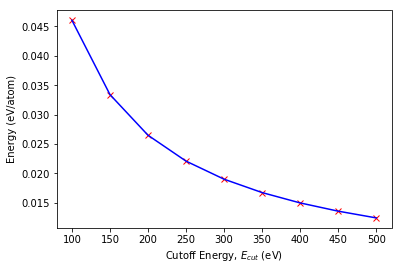

In [18]:
toy_ENCUTS = [100, 150, 200, 250, 300, 350, 400, 450, 500]
toy_energies = [log(i)/i for i in example_ENCUTS]

# Example usage for plot_convergence
plot_convergence(toy_ENCUTS, toy_energies, 
                 xlabel="Cutoff Energy, $E_{cut} $ (eV)", 
                 ylabel="Energy (eV/atom)")

### Part B: KPOINTS convergence test

Similarly, we have prepared a set of convergence test runs for different k-point densities, which can be found in the directory [convergence_test_results/KPOINTS_convergence](convergence_test_results/KPOINTS_convergence). Each subfolder of Si_BSn and Si_DC corresponds to a different value for ENCUT. Using the value of ENCUT you found in Part 2B, plot the convergence with k-point density. The k-points are generated using a standard method Monkhorst-Pack; the original paper by Monkhorst and Pack has been posted to bCourse. 

You will incrementally increase the fineness of the k-points grid until a convergence is attained to within 10 meV (do this by selecting which data you plot). You will use results from 2x2x2 to 12x12x12 until convergence is obtained. **You must find the correct value for ENCUT prior to proceeding any further in the project.**

---

### Part C: Critical Evaluation of DFT Calculations

The following is an excerpt from a paper which proports to have used *ab initio* density functional theory to study a new energy material, sherburnium. 

> *Ab-initio* density functional theory calculations were performed to determine the ground state structure, band gap, and phase stability of a new energy material, sherburnite. All calculations were performed using the Vienna Ab-initio Simulation Package (VASP) using a Gaussian-type basis set for periodic systems. Exchange-correlation effects of the electronic density are accounted for using the Perdew–Burke–Ernzerhof (PBE) functional and a mesh of 1000 k-points per reciprocal atom were used with a cutoff energy of 250eV (thus allowing efficient calculations). Although a phase transformation has been observed above 300K from the cubic dagdeline phase to the tetragonal sherburnite phase, our calculations show that the ground state energy of the tetragonal phase at 0K is actually 0.010 eV lower than that of the cubic phase. This indicates that the cubic dagdeline phase is only metastable at low temperatures. We calculate tetragonal sherburnite’s band gap to be 1.90 eV, which indicates the compound may also be a good candidate for X APPLICATION, which is widely believed to required a bandgap below 2.0 eV...

In your report, please evaluate the calculation details of this study and discuss any problems with the authors' methodology, understanding of VASP, or interpretation of their results. 

---